## CNN project


# Ammar An
### www.facebook.com/pythonHoms

In [1]:
# ! pip install torchvision

In [2]:
import torch
import torch.nn as nn
# to download the dataset:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
torch.cuda.is_available()
import matplotlib.pyplot as plt


In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [4]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [5]:
print(train_dataset.data.size())
print('-------------------------')
print(test_dataset.data.size())


torch.Size([60000, 28, 28])
-------------------------
torch.Size([10000, 28, 28])


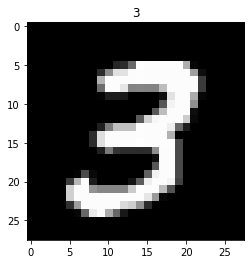

In [6]:
plt.imshow(train_dataset.data[7], cmap='gray')
plt.title('%i' % train_dataset.targets[7])
plt.show()

In [7]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_load = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [8]:
dataiter = iter(train_load)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)


torch.Size([100, 1, 28, 28])
torch.Size([100])


In [9]:
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))
print("Number of batches in the train loader: {}".format(len(train_load)))
print("Number of batches in the test loader: {}".format(len(test_load)))

Number of images in training set: 60000
Number of images in test set: 10000
Number of batches in the train loader: 600
Number of batches in the test loader: 100


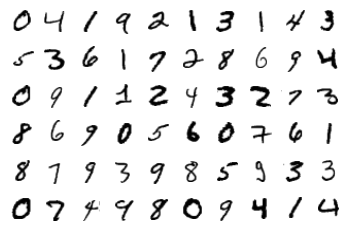

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [11]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # input_size: 28
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    # input_size-filter_size +2(padding)/stride + 1 = 28-3+2(1)/1+1=28

    self.batchnorm1 = nn.BatchNorm2d(8)
    # output_channel:8, batch(8)

    self.relu = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    #input_size=28/2=14

    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    # same_padding: (5-1)/2=2:padding_size. 
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    # input_size=14/2=7
    # 32x7x7=1568

    self.fc1 = nn.Linear(in_features=1568, out_features=600)
    self.fc2 = nn.Linear(in_features=600, out_features=10)

  def forward(self, x):
    # print('input shape', x.shape)
    out = self.cnn1(x)
    # print('Cnn1 output', out.shape) # N, C, H, W
    out = self.batchnorm1(out)
    # print('batch', out.shape)
    out = self.relu(out)
    out = self.maxpool1(out)
    # print('max pool shape', out.shape) # 100, 8, 14, 14
    out = self.cnn2(out)
    # print('cnn2 shape', out.shape) # 100, 32, 14, 14
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool2(out)
    # print('max pool 2', out.shape) # 100, 32, 7, 7
    out = out.view(-1, 1568)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    return out


In [12]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 10
model = CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [13]:
def train_CNN(model, criterion, optimizer, dataLoader, device):
    losses = []
    acc = []
    model.train()
    total = 0
    correct = 0.0
    running_loss = 0.0
    running_corrects = 0.0
    for data in dataLoader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
            
        outputs = model(images)
        # print(outputs.shape)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
 
        running_loss += loss.item() * images.size(0) 
        # This: correct += (preds == labels).sum().item() and this: running_corrects += torch.sum(preds == labels.data) are the same.
        running_corrects += torch.sum(preds == labels.data)
        # total += labels.size(0)

    epoch_loss = running_loss / len(dataLoader)
    epoch_acc = running_corrects / len(dataLoader)
    # print('accuarcy 1', epoch_acc)
    # print('accuarcy 2', 100*correct/total)

    return epoch_acc, epoch_loss


In [14]:
def vaildate_CNN(model, criterion, dataLoader, device):
    losses = []
    acc = []
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    for data in dataLoader:
        images, labels = data
        images = images.to(device) 
        labels = labels.to(device) 
         
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0) 
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataLoader)
    epoch_acc = running_corrects.double() / len(dataLoader)
    return epoch_acc, epoch_loss


In [32]:
epochess = []
train_losses = []
test_losses = []
acc_training = []
acc_testing = []
for epoch in range(epochs):
    train_acc, train_epoch_loss = train_CNN(model, loss_function, optimizer, train_load, device)
    print('epoch', epoch, 'training loss', train_epoch_loss)
    train_losses.append(train_epoch_loss)
    print('epoch', epoch, 'training accuarcy', train_acc)
    acc_training.append(train_acc)

    test_acc, test_epoch_loss = vaildate_CNN(model, loss_function, test_load, device)
    print('epoch', epoch, 'testing loss', test_epoch_loss)
    test_losses.append(test_epoch_loss)
    print('epoch', epoch, 'testing accuarcy', test_acc)
    acc_testing.append(test_acc)

    epochess.append(epoch)



epoch 0 training loss 41.253136118253074
epoch 0 training accuarcy tensor(90.5367)
epoch 0 testing loss 13.961470649577677
epoch 0 testing accuarcy tensor(95.8800, dtype=torch.float64)
epoch 1 training loss 11.822919902391732
epoch 1 training accuarcy tensor(96.7450)
epoch 1 testing loss 8.952337429858744
epoch 1 testing accuarcy tensor(97.2700, dtype=torch.float64)
epoch 2 training loss 8.623051335414251
epoch 2 training accuarcy tensor(97.5933)
epoch 2 testing loss 7.105934139341116
epoch 2 testing accuarcy tensor(97.7900, dtype=torch.float64)
epoch 3 training loss 7.050761662346001
epoch 3 training accuarcy tensor(98.0133)
epoch 3 testing loss 6.113345852936618
epoch 3 testing accuarcy tensor(97.9900, dtype=torch.float64)
epoch 4 training loss 6.066483482640858
epoch 4 training accuarcy tensor(98.2933)
epoch 4 testing loss 5.475036735297181
epoch 4 testing accuarcy tensor(98.1200, dtype=torch.float64)
epoch 5 training loss 5.374737290355067
epoch 5 training accuarcy tensor(98.4767)


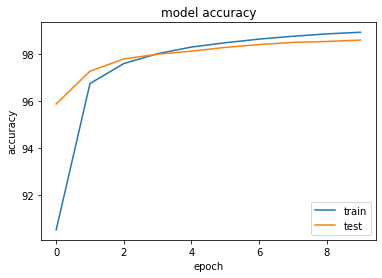

In [42]:
plt.plot(epochess, acc_training, acc_testing)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

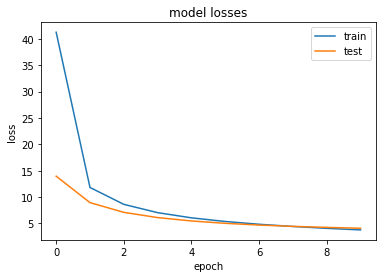

In [43]:
plt.plot(epochess, train_losses, test_losses)
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [44]:
torch.save(model.state_dict(), './cnn_model.pt')

## load the model

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model = CNN().to(device)
cnn_model.load_state_dict(torch.load('./cnn_model.pt'))

<All keys matched successfully>

In [16]:
accuarcy, loss = vaildate_CNN(cnn_model, loss_function, test_load, device)
print('model accuarcy is ', accuarcy )

model accuarcy is  tensor(98.5900, dtype=torch.float64)


In [17]:
# !pip install shap==0.30.1

In [18]:
def get_background_classes(data_loader):
    mean = torch.zeros([10,1,28,28])
    label_count = torch.zeros(10)
    for images, labels in data_loader:
        for image, label in zip(images, labels):
            mean[label] += image
            label_count[label] += 1
    for i in range(10):
        mean[i] = mean[i]/label_count[i]
    return mean

In [19]:
background = get_background_classes(train_load).to(device)

In [20]:
batch = iter(train_load)
images, labels = next(batch)
test_images = images[1:4].to(device)

In [21]:
labels[1:4]

tensor([0, 4, 1])

In [22]:
test_images.shape

torch.Size([3, 1, 28, 28])

In [23]:
import numpy as np
import shap

test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)


In [24]:
def shap_plot(model, test_images, test_numpy, background):    
    e = shap.GradientExplainer(model, background)
    shap_values = e.shap_values(test_images)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    shap.image_plot(shap_numpy, -test_numpy)

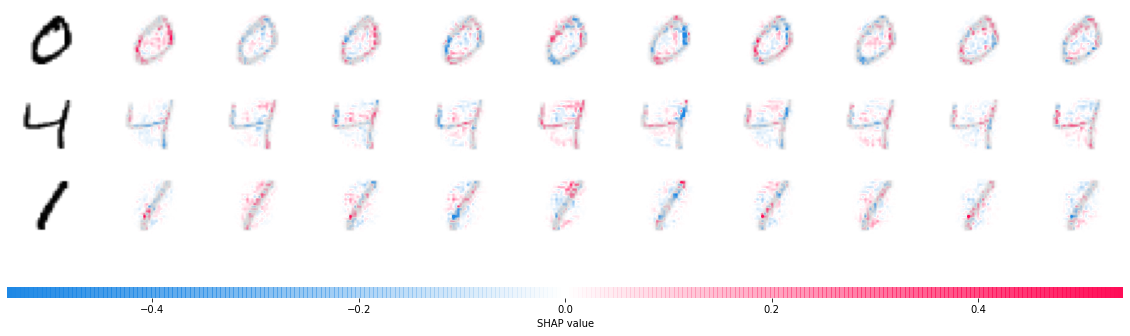

In [25]:
shap_plot(cnn_model, test_images, test_numpy, background)